**The command is not a standard IPython magic command. It is designed for use within Fabric notebooks only.**

In [1]:
%pip install PyMuPDF azure.kusto.data azure.kusto.ingest pandas openai tiktoken pymupdf4llm umap-learn langchain

StatementMeta(, 5a76ba71-1d2e-4a5a-b947-947d6fc2e399, 7, Finished, Available, Finished)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.6/66.6 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 127.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.6/405.6 kB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 701.4/701.4 kB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 124.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

 Create a SparkSession if you don't already have one

In [2]:
from pyspark.sql import SparkSession

# Create a SparkSession if you don't already have one
spark = SparkSession.builder \
    .appName("PandasToSpark") \
    .getOrCreate()


# In[3]:


import pymupdf # imports the pymupdf library
from notebookutils import mssparkutils
import fitz
import os
from openai import AzureOpenAI
import tiktoken
import pymupdf4llm
from langchain.text_splitter import RecursiveCharacterTextSplitter
import uuid
import re
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

StatementMeta(, 5a76ba71-1d2e-4a5a-b947-947d6fc2e399, 9, Finished, Available, Finished)

In [3]:
client = AzureOpenAI(
        api_key='6X84dvUYiaZrPUsBjg8S1nFiGlkThg6eUJYGClcBFGVfSnUW6Xa0JQQJ99BDACYeBjFXJ3w3AAAAACOGt4jK',
        api_version="2024-12-01-preview",
        azure_endpoint='https://aifoundry2025demo.openai.azure.com/'
        )

StatementMeta(, 5a76ba71-1d2e-4a5a-b947-947d6fc2e399, 10, Finished, Available, Finished)

**#Step 1 : extract text from PDF and also perform chunking using langchain **

In [4]:
def extract_markdown(path:str,file:str)-> str:
    metadata={}
    all_chunks = []
    # document_id = uuid.uuid4()
    markdown = pymupdf4llm.to_markdown(path)
    section_splitter = RecursiveCharacterTextSplitter(
        chunk_size=300,  # Smaller chunks (was 1000)
        chunk_overlap=30,  # Less overlap (was 100)
        separators=["\n## ", "\n# ", "\n", ". ", "? ", "! ", ";", ":", " - ", ",", " "]
    ) 
    chunks = section_splitter.split_text(markdown)
    print(f"chunks : {len(chunks)}")
    for i,chunk in enumerate( chunks ):

        metadata = {
            # 'document_id': str(document_id),
            # 'chunk_id' :f"{document_id}-{i}",
            'total_chunks':len(chunks),
            'file_name':file 
        }
        chunk= chunk.replace("#","")
        chunk = chunk.replace("*","")
        chunk = chunk.replace("","")
        chunk = chunk.replace("\n","")
        chunk_row = {
            'content': chunk,
            **metadata  # Unpack metadata into the row
        }
        all_chunks.append(chunk_row)
    return all_chunks

StatementMeta(, 5a76ba71-1d2e-4a5a-b947-947d6fc2e399, 11, Finished, Available, Finished)

**#step 2: check tokens**

**function to generate embedding** 

In [5]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens



def embed(query):
    deployment_name = "text-embedding-ada-002"
    response = client.embeddings.create(input=query, model=deployment_name)
    response = response.data[0].embedding
    return response

StatementMeta(, 5a76ba71-1d2e-4a5a-b947-947d6fc2e399, 12, Finished, Available, Finished)

In [6]:
pdf_path = "abfss://ws_RTI_AI2025build@onelake.dfs.fabric.microsoft.com/LK_RTIAI.Lakehouse/Files/data"
_markdown=[]
files = mssparkutils.fs.ls(pdf_path)
row = []
for file in files:
    file_name = file.name
    # _text = extraxt_text(f"/lakehouse/default/Files/data/{file_name}")
    _markdown += extract_markdown(f"/lakehouse/default/Files/data/{file_name}",file_name)
    # markdown_token = num_tokens_from_string(_markdown,"cl100k_base")
    # text_token = num_tokens_from_string(_text,"cl100k_base")
    # _embedding = embed(_markdown)
    # file_name_embedding = embed(file_name.split('.pdf')[0])

    # row_dict = {
    #         "filename": file_name,
    #         # "text": _text,
    #         "markdown" : ''.join(str(x) for x in _markdown),
    #         "metadata" :metadata,
    #         # "text_token":text_token,
    #         "markdown_token":markdown_token,
    #         "embedding":_embedding.data[0].embedding,
    #         "file_name_embedding":file_name_embedding.data[0].embedding
    #         }


StatementMeta(, 5a76ba71-1d2e-4a5a-b947-947d6fc2e399, 13, Finished, Available, Finished)

chunks : 43
chunks : 41
chunks : 21
chunks : 36


In [14]:
import pandas as pd
df = pd.DataFrame(_markdown)
df['embedding'] = df['content'].apply(embed)
# print(df)

#convert to spark
spark_df = spark.createDataFrame(df)


# In[ ]:


# step 5 : setup kusto connector
AAD_TENANT_ID = "022b1a06-dd63-4b33-91f8-1bfa27de5d6d"
KUSTO_CLUSTER =  "https://trd-yqzkmcv0cxxtjvrwcn.z5.kusto.fabric.microsoft.com"
KUSTO_DATABASE = "EV_RTI_AI"
KUSTO_TABLE = "Resume"
kustoOptions = {"kustoCluster": KUSTO_CLUSTER, "kustoDatabase" :KUSTO_DATABASE, "kustoTable" : KUSTO_TABLE }
access_token = mssparkutils.credentials.getToken(KUSTO_CLUSTER)




StatementMeta(, 5a76ba71-1d2e-4a5a-b947-947d6fc2e399, 21, Finished, Available, Finished)

In [15]:
accessToken = mssparkutils.credentials.getToken(KUSTO_CLUSTER)
print(accessToken)

StatementMeta(, 5a76ba71-1d2e-4a5a-b947-947d6fc2e399, 22, Finished, Available, Finished)

[REDACTED]


In [16]:
spark_df.write. \
format("com.microsoft.kusto.spark.synapse.datasource").\
option("kustoCluster","https://trd-yqzkmcv0cxxtjvrwcn.z5.kusto.fabric.microsoft.com").\
option("kustoDatabase",kustoOptions["kustoDatabase"]).\
option("kustoTable", kustoOptions["kustoTable"]).\
option("accessToken",accessToken).\
option("tableCreateOptions", "CreateIfNotExist").mode("Append").save()

StatementMeta(, 5a76ba71-1d2e-4a5a-b947-947d6fc2e399, 23, Finished, Available, Finished)

In [18]:
#Step 7 : prepare question for similarity search and query eventhouse 
search_query = "Which city is the cleanest and has best Air quality index"
search_embed = embed(search_query)
searchedEmbedding = search_embed
KustoQuery = f"Resume | extend similarity = series_cosine_similarity(dynamic("+str(searchedEmbedding)+"), embedding) | top 4 by similarity desc"

StatementMeta(, 5a76ba71-1d2e-4a5a-b947-947d6fc2e399, 25, Finished, Available, Finished)

In [20]:
#read from KQL
new_df = spark.read.\
        format("com.microsoft.kusto.spark.synapse.datasource"). \
        option("kustoCluster","https://trd-yqzkmcv0cxxtjvrwcn.z5.kusto.fabric.microsoft.com"). \
        option("kustoDatabase",kustoOptions["kustoDatabase"]). \
        option("kustoQuery", KustoQuery).\
        option("accessToken", mssparkutils.credentials.getToken("https://trd-yqzkmcv0cxxtjvrwcn.z5.kusto.fabric.microsoft.com")).load()

StatementMeta(, 5a76ba71-1d2e-4a5a-b947-947d6fc2e399, 27, Finished, Available, Finished)

In [21]:
display( new_df)



StatementMeta(, 5a76ba71-1d2e-4a5a-b947-947d6fc2e399, 28, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 1964e1a5-ec4e-4fb3-83da-eb60e09ed9df)

**function to call OpenAI GPT model**

In [22]:

def Call_openAi(text):
    response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=text,
            temperature=0
    )
    return response.choices[0].message.content

StatementMeta(, 5a76ba71-1d2e-4a5a-b947-947d6fc2e399, 29, Finished, Available, Finished)

**function to get cosine similarity from Eventhouse**

In [23]:
def fetch_similarity_eventhouse(question:str):
    searchedEmbedding = embed(question)
    KustoQuery = f"Resume | extend similarity = series_cosine_similarity(dynamic("+str(searchedEmbedding)+"), embedding) | top 2 by similarity desc"
    KustoDf = spark.read.\
        format("com.microsoft.kusto.spark.synapse.datasource"). \
        option("kustoCluster","https://trd-yqzkmcv0cxxtjvrwcn.z5.kusto.fabric.microsoft.com"). \
        option("kustoDatabase",kustoOptions["kustoDatabase"]). \
        option("kustoQuery", KustoQuery).\
        option("accessToken", mssparkutils.credentials.getToken("https://trd-yqzkmcv0cxxtjvrwcn.z5.kusto.fabric.microsoft.com")).load()
    return KustoDf

StatementMeta(, 5a76ba71-1d2e-4a5a-b947-947d6fc2e399, 30, Finished, Available, Finished)

In [24]:
#step 10 : Ask questions from GPT model
search_query = "Find the cleanest city which has best Air quality index"
Answer_from_eventhouse = fetch_similarity_eventhouse(search_query)

Answer = ""

for row in Answer_from_eventhouse.rdd.toLocalIterator():
    Answer= Answer+" " + row['file_name']
# find_file_name = Answer_from_eventhouse['']

prompt = 'Question: {}'.format(search_query) +'\n'+'Information: {}'.format(Answer)

messages = [{"role":"system","content":"you are help assistant answering questions from users and You will only give the file name from the information provided."},
{"role":"user","content":prompt }] 

result = Call_openAi(messages)
display(result)


StatementMeta(, 5a76ba71-1d2e-4a5a-b947-947d6fc2e399, 31, Finished, Available, Finished)

'Top Contenders for Cleanest City.pdf'

In [26]:
# function to decompose vectors and create clusters

def visualize_document_clusters(df, n_clusters=4, method='umap'):
    # Extract embeddings
    embeddings = np.array(df['embedding'].tolist())
    
    # Perform clustering on the original embeddings
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(embeddings)
    
    # Reduce dimensions for visualization
    if method.lower() == 'pca':
        reducer = PCA(n_components=2)
    elif method.lower() == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    elif method.lower() == 'umap':
        reducer = umap.UMAP(n_components=2, random_state=42)
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    
    # Create visualization
    plt.figure(figsize=(12, 10))
    
    # Plot points colored by cluster
    scatter = plt.scatter(
        reduced_embeddings[:, 0],
        reduced_embeddings[:, 1],
        c=clusters,
        cmap='tab10',
        s=100,
        alpha=0.8
    )
    
    # Add labels
    #for i, (x, y) in enumerate(reduced_embeddings):
        #plt.annotate(df['file_name'].iloc[i], (x, y), fontsize=8)
    
    # Add cluster centers
    centers_reduced = reducer.transform(kmeans.cluster_centers_)
    plt.scatter(
        centers_reduced[:, 0],
        centers_reduced[:, 1],
        c='black',
        s=200,
        alpha=0.5,
        marker='X'
    )
    
    plt.title(f'Document Clusters Visualized with {method.upper()}')
    plt.colorbar(scatter, label='Cluster')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Return DataFrame with cluster information
    result_df = df.copy()
    result_df['cluster'] = clusters
    return result_df

StatementMeta(, 5a76ba71-1d2e-4a5a-b947-947d6fc2e399, 33, Finished, Available, Finished)

StatementMeta(, 5a76ba71-1d2e-4a5a-b947-947d6fc2e399, 34, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/nfs4/pyenv-9480fec7-3047-4c75-8e2c-cd1b101b09e4/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


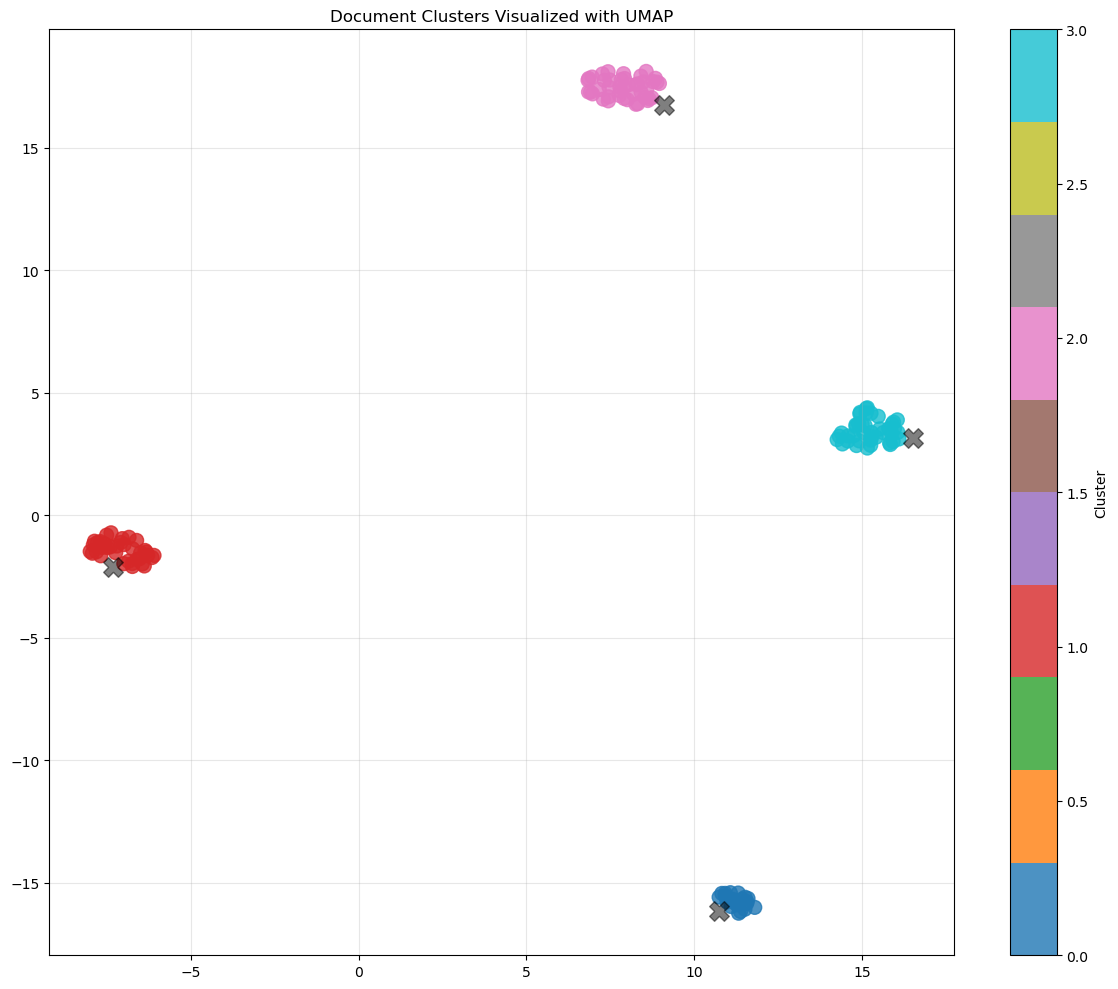

,content,total_chunks,file_name,embedding,cluster
0,How AI Works: A Comprehensive Guide Artificia...,43,How AI Works.pdf,"[-0.007396290544420481, 0.005085750948637724, ...",2
1,"delves into the core concepts, techniques, and...",43,How AI Works.pdf,"[-0.018953954800963402, -0.01660567708313465, ...",2
2,"human intelligence, such as: Learning: Acquir...",43,How AI Works.pdf,"[-0.017295870929956436, 0.02407502755522728, 0...",2
3,"Perception: Interpreting sensory input, such a...",43,How AI Works.pdf,"[-0.00772232748568058, 0.017301755025982857, 0...",2
4,By Capability Narrow or Weak AI: Designed to ...,43,How AI Works.pdf,"[-0.01821146160364151, -0.002736740978434682, ...",2
...,...,...,...,...,...
136,can contaminate water sources. Resource Consu...,36,Top Contenders for Cleanest City.pdf,"[0.04445245862007141, -0.01556225772947073, 0....",1
137,"heat waves, floods, and droughts, which can im...",36,Top Contenders for Cleanest City.pdf,"[0.009177327156066895, -0.002302490873262286, ...",1
138,approaches to address the challenges of urban ...,36,Top Contenders for Cleanest City.pdf,"[0.02846391499042511, 0.0030747647397220135, -...",1
139,"management, transportation, and energy efficie...",36,Top Contenders for Cleanest City.pdf,"[0.022711632773280144, -0.003344906261190772, ...",1


In [27]:
visualize_document_clusters(df)

**function to extract text from pdf using pymuhpdf library**

In [29]:

def extraxt_text(path:str)-> str:
    text=''
    try:
        with fitz.open(path) as doc:
            for page in doc:
                text +=page.get_text()
                text = text.replace("\n", " ")
    except Exception as e:
        print(f'error from {e}')
    return text

StatementMeta(, 5a76ba71-1d2e-4a5a-b947-947d6fc2e399, 36, Finished, Available, Finished)

In [30]:
def chunk_resume_by_sections(resume_text):
    """Split resume into logical sections"""
    # Common resume section headers (expand as needed)
    section_patterns = [
        r"EDUCATION|ACADEMIC BACKGROUND",
        r"EXPERIENCE|WORK HISTORY|EMPLOYMENT",
        r"SKILLS|TECHNICAL SKILLS|COMPETENCIES",
        r"PROJECTS|PROJECT EXPERIENCE",
        r"CERTIFICATIONS|LICENSES",
        r"LANGUAGES|LANGUAGE PROFICIENCY"
    ]
    
    # Combine patterns
    combined_pattern = "|".join(section_patterns)
    
    # Find section headers
    import re
    headers = list(re.finditer(combined_pattern, resume_text, re.IGNORECASE))
    
    # Extract sections
    sections = []
    for i in range(len(headers)):
        start = headers[i].start()
        end = headers[i+1].start() if i < len(headers)-1 else len(resume_text)
        section_text = resume_text[start:end].strip()
        section_type = headers[i].group(0).upper()
        
        sections.append({
            "type": section_type,
            "content": section_text
        })
    #print(sections)
    return sections

StatementMeta(, 5a76ba71-1d2e-4a5a-b947-947d6fc2e399, 37, Finished, Available, Finished)

In [31]:
#optional : Clean text
def clean_text_and_remove_categories(text):
    """Clean text and remove category headers"""
    
    # First, remove common markdown formatting
    text = text.replace("#", "").replace("*", "").replace("\n", "")
    
    # Common resume section headers to remove
    section_patterns = [
        r"EDUCATION|ACADEMIC BACKGROUND",
        r"EXPERIENCE|WORK HISTORY|EMPLOYMENT",
        r"SKILLS|TECHNICAL SKILLS|COMPETENCIES",
        r"PROJECTS|PROJECT EXPERIENCE",
        r"CERTIFICATIONS|LICENSES",
        r"LANGUAGES|LANGUAGE PROFICIENCY"
    ]
    
    # Combine patterns
    combined_pattern = "|".join(section_patterns)
    
    # Replace section headers with empty string
    text = re.sub(combined_pattern, "", text, flags=re.IGNORECASE)
    
    # Remove extra whitespace created by deletions
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


# In[92]:


# optional : If chunking required as per sections
def extract_markdown(path:str,file:str)-> str:
    metadata={}
    all_chunks = []
    # document_id = uuid.uuid4()
    markdown = pymupdf4llm.to_markdown(path)
    chunked_resumes = []

    sections = chunk_resume_by_sections(markdown)
        
    for section in sections:
        chunked_resumes.append({
                "source": path,
                "section_type": section["type"],
                "content": section["content"]
            })
    print(f"chunks : {len(sections)}")
    
    return chunked_resumes


StatementMeta(, 5a76ba71-1d2e-4a5a-b947-947d6fc2e399, 38, Finished, Available, Finished)